In [1]:
from matplotlib.backends.backend_template import show
from pandas import read_csv
import statsmodels
import numpy as np
import quandl

quandl.ApiConfig.api_key = "hkdUt265S_BuPkiCFNqk"

In [2]:
data = quandl.get("EIA/PET_RWTC_D", returns="pandas")

In [3]:
import requests
databases = []
page = 1
while(page is not None):
    payload = requests.get("https://www.quandl.com/api/v3/databases?api_key={}&page={}"\
                    .format(quandl.ApiConfig.api_key, page)).json()
    databases += payload['databases']
    page = payload['meta']['next_page']

In [4]:
!pip install pixiedust

In [4]:
msft = quandl.get('WIKI/MSFT')
msft['daily_spread'] = msft['Adj. Close'].diff()
msft = msft.reset_index()

In [12]:
import pixiedust
import pandas as pd
tail = msft[msft['Date'] > '2016-05-16']
investment = np.cumsum((10000 / tail['Adj. Close'].values[0]) * tail['daily_spread']) + 10000
investment = investment.astype(int)
investment.index = tail['Date']
investment = investment.resample('M').mean()
investment = pd.DataFrame(investment).reset_index()
pixiedust.display(investment)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

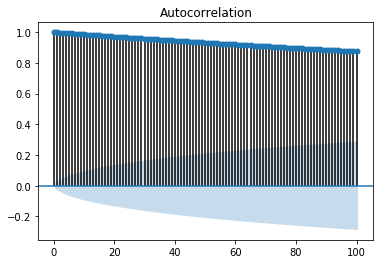

In [6]:
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
smt.graphics.plot_acf(msft['Adj. Close'], lags=100)
plt.show()

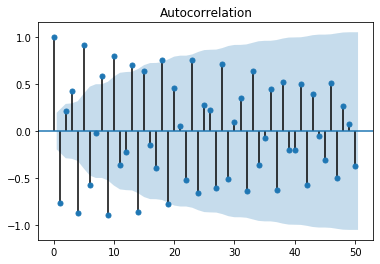

In [7]:
smt.graphics.plot_acf(np.cos(np.linspace(0, 1000, 100)), lags=50)
plt.show()

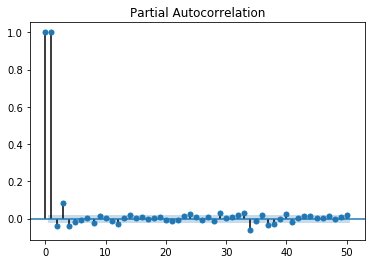

In [8]:
import statsmodels.tsa.api as smt
smt.graphics.plot_pacf(msft['Adj. Close'], lags=50)
plt.show()

In [10]:
train_set, test_set = msft[:-14], msft[-14:]

In [13]:
logmsft = np.log(train_set['Adj. Close'])
logmsft.index = train_set['Date']
logmsft_diff = pd.DataFrame(logmsft - logmsft.shift()).reset_index()
logmsft_diff.dropna(inplace=True)
pixiedust.display(logmsft_diff)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from statsmodels.tsa.stattools import adfuller
import pprint

ad_fuller_results = adfuller(
logmsft_diff['Adj. Close'], autolag = 'AIC', regression = 'c'
)
labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
pp = pprint.PrettyPrinter(indent=4)
pp.pprint({labels[i]: ad_fuller_results[i] for i in range(4)})

{   '#Lags Used': 3,
    'Number of Observations Used': 8057,
    'Test Statistic': -48.07159213859097,
    'p-value': 0.0}


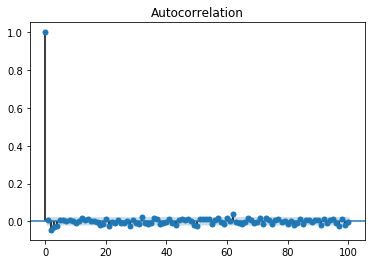

In [15]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(logmsft_diff['Adj. Close'], lags=100)
plt.show()



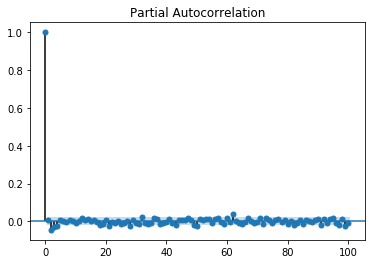

In [16]:
smt.graphics.plot_pacf(logmsft_diff['Adj. Close'], lags=100)
plt.show()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [37]:
from statsmodels.tsa.arima_model import ARIMA

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arima_model_class = ARIMA(train_set['Adj. Close'], order=(1,1,1), missing='none')
    arima_model = arima_model_class.fit(disp=0)

    print(arima_model.resid.describe())

count    8.061000e+03
mean    -5.542536e-07
std      4.198119e-01
min     -5.118915e+00
25%     -1.061132e-01
50%     -1.184449e-02
75%      9.848491e-02
max      5.023380e+00
dtype: float64


KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

<Figure size 864x360 with 0 Axes>

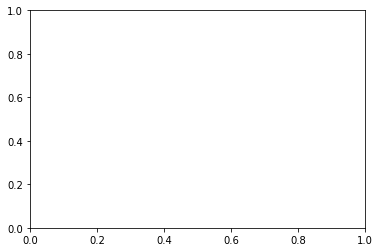

In [38]:
def plot_predict(model, dates_series, num_observations):
    fig = plt.figure(figsize = (12,5))
    model.plot_predict(
        start = str(dates_series[len(dates_series)-num_observations]),
        end = str(dates_series[len(dates_series)-1])
    )
    plt.show()

plot_predict(arima_model, train_set['Date'], 100)
plot_predict(arima_model, train_set['Date'], 10)

In [40]:
def compute_test_set_predictions(train_set, test_set):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        history = train_set['Adj. Close'].values
        forecast = np.array([])
        for t in range(len(test_set)):
            prediction = ARIMA(history, order=(1,1,0)).fit(disp=0).forecast()
            history = np.append(history, test_set['Adj. Close'].iloc[t])
            forecast = np.append(forecast, prediction[0])
        return pd.DataFrame(
          {"forecast": forecast,
           "test": test_set['Adj. Close'],
           "Date": pd.date_range(start=test_set['Date'].iloc[len(test_set)-1], periods = len(test_set))
          }
        )

results = compute_test_set_predictions(train_set, test_set)
pixiedust.display(results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from sklearn.metrics import mean_squared_error
def compute_mean_squared_error(test_series, forecast_series):
    return mean_squared_error(test_series, forecast_series)

print('Mean Squared Error: {}'.format(
compute_mean_squared_error( test_set['Adj. Close'], results.forecast))
)




Mean Squared Error: 6.336538823059039
